# [Conversational RAG](https://python.langchain.com/docs/tutorials/qa_chat_history/)

会話型RAGは一般に言うQ&Aアプリケーションです。
Q&Aアプリケーションでは、ユーザーとのやり取りを「メモリ」に保持し、それらを現在の思考に組み込むためのロジックが必要です。  

このチュートリアルでは、会話履歴をメモリに保持し、プロンプトに組み込む方法を学びます。

## 参考


- [create_stuff_documents_chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html)  
受け取った入力を要約や他の処理を行わず、すべてプロンプトに詰め込む(stuff)  
今回の場合、 `input` と `context` をキーに持つ辞書を入力に持ち、入力された内容をすべてプロンプトテンプレートに詰め込む
- [create_retrieval_chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.retrieval.create_retrieval_chain.html)  
`input` をキーに持つ辞書を入力に持ち、入力で渡されたキーと `context` (検索結果) をキーに持つ辞書を出力する



# ■ プレビュー

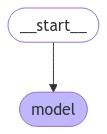

In [95]:
import os
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36"

from typing import List, Sequence
from typing_extensions import TypedDict, Annotated
from IPython.display import Image, display
import bs4
from langchain_core.documents import Document
from langchain_core.runnables import Runnable
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder, AIMessagePromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig

# モデル
llm = ChatOpenAI(model="gpt-4o")

#
# 1. ロード & 分割 & 保存
#

# ロード
bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(parse_only=bs4_strainer)
)
docs: List[Document] = loader.load()

# 分割
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
splits: List[Document] = text_splitter.split_documents(docs)

# 保存
vectorstore = InMemoryVectorStore.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# 取得
retriever = vectorstore.as_retriever()
def format_docs(docs: List[Document]) -> str:
    return "\n".join([doc.page_content for doc in docs])


#
# 2. Retrieverの作成
# 会話履歴とクエリを使ってクエリを再作成し、そのクエリを検索するRetrieverを作成する
#

# クエリと会話履歴から独立した質問を作成するためのプロンプト
contextualize_q_system_prompt = """
チャット履歴と、チャット履歴のコンテキスを参照する可能性のある最新のユーザーからの質問がある場合、チャット履歴なしで理解できる独立した質問を作成してください。
質問には答えず、必要であれば作り直し、そうでなければそのまま返してください。
"""
contextualize_q_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),  # 入力にchat_historyというキーがあると、それを会話履歴として展開する
    HumanMessagePromptTemplate.from_template("{input}"),
])

# クエリ(input: str) と 会話履歴(chat_history: List[BaseMessage]) からクエリを作成して、Retrieverで検索するチェイン
history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)


#
# 3. Retrieverを質問応答のチェインに組み込む
#

system_template = """
あなたは質問応答のアシスタントです。
質問に答えるために、検索された文脈の以下の部分を使用してください。
答えがわからない場合は、わからないと答えましょう。
回答は3文以内で簡潔に。


{context}
"""

qa_prompt = ChatPromptTemplate([
    SystemMessagePromptTemplate.from_template(system_template),
    MessagesPlaceholder("chat_history"),
    HumanMessagePromptTemplate.from_template("{input}")
])

question_answer_chain = create_stuff_documents_chain(llm=llm, prompt=qa_prompt, output_parser=StrOutputParser())

rag_chain = create_retrieval_chain(retriever=history_aware_retriever, combine_docs_chain=question_answer_chain)

#
# 4. LangGraphで会話履歴を自動更新
#

class State(TypedDict):
    input: str
    chat_history: Annotated[List[BaseMessage], add_messages]
    context: str
    answer: str
    
def call_model(state: State, config: RunnableConfig):
    result = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(content=state["input"]),
            AIMessage(content=result["answer"])
        ],
        "context": result["context"],
        "answer": result["answer"],
    }

workflow = StateGraph(state_schema=State)
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# mermaidでグラフを可視化してPNG形式で出力
display(Image(app.get_graph().draw_mermaid_png()))

In [96]:
from pprint import pprint

config = RunnableConfig(configurable={"thread_id": "23456"})
response = app.invoke(input={"input": "タスク分解とは何ですか?"}, config=config)
pprint(response)

{'answer': 'タスク分解とは、大きなタスクを複数の小さくて管理しやすいタスクに分解するプロセスです。これは、複雑なタスクを簡素化し、ステップバイステップで解決するために、モデルのパフォーマンスを向上させる方法として使用されます。',
 'chat_history': [HumanMessage(content='タスク分解とは何ですか?', additional_kwargs={}, response_metadata={}, id='82c14712-658a-4bfd-917b-c3946acd1e0f'),
                  AIMessage(content='タスク分解とは、大きなタスクを複数の小さくて管理しやすいタスクに分解するプロセスです。これは、複雑なタスクを簡素化し、ステップバイステップで解決するために、モデルのパフォーマンスを向上させる方法として使用されます。', additional_kwargs={}, response_metadata={}, id='5103b10e-be9e-41a8-88f4-7dc449114251')],
 'context': [Document(id='6ccdfc8b-084b-4101-bb46-1f65bb5cdbfc', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with 

In [97]:
# クエリと会話履歴から独立した質問を生成して、Retriverで検索
# 会話履歴と合わせて、「タスク分解は一般的な手法ですか？」というクエリが生成される。出力はそのクエリをRetrieverで検索した結果
response = app.invoke(input={"input": "それは一般的な手法ですか?"}, config=config)
pprint(response)

{'answer': 'はい、タスク分解は、Chain of '
           'Thought（CoT）のような手法を通じて、複雑なタスクの解決を支援するために一般的に用いられる手法です。',
 'chat_history': [HumanMessage(content='タスク分解とは何ですか?', additional_kwargs={}, response_metadata={}, id='82c14712-658a-4bfd-917b-c3946acd1e0f'),
                  AIMessage(content='タスク分解とは、大きなタスクを複数の小さくて管理しやすいタスクに分解するプロセスです。これは、複雑なタスクを簡素化し、ステップバイステップで解決するために、モデルのパフォーマンスを向上させる方法として使用されます。', additional_kwargs={}, response_metadata={}, id='5103b10e-be9e-41a8-88f4-7dc449114251'),
                  HumanMessage(content='それは一般的な手法ですか?', additional_kwargs={}, response_metadata={}, id='d211b0e3-d596-468b-931d-1d33707c0b41'),
                  AIMessage(content='はい、タスク分解は、Chain of Thought（CoT）のような手法を通じて、複雑なタスクの解決を支援するために一般的に用いられる手法です。', additional_kwargs={}, response_metadata={}, id='db241116-0def-4649-9b1f-1016f7b663c7')],
 'context': [Document(id='6ccdfc8b-084b-4101-bb46-1f65bb5cdbfc', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_conten

In [98]:
# Graphのステートから会話履歴を確認してみる
chat_history = app.get_state(config).values["chat_history"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

タスク分解とは何ですか?
================================== Ai Message ==================================

タスク分解とは、大きなタスクを複数の小さくて管理しやすいタスクに分解するプロセスです。これは、複雑なタスクを簡素化し、ステップバイステップで解決するために、モデルのパフォーマンスを向上させる方法として使用されます。
================================ Human Message =================================

それは一般的な手法ですか?
================================== Ai Message ==================================

はい、タスク分解は、Chain of Thought（CoT）のような手法を通じて、複雑なタスクの解決を支援するために一般的に用いられる手法です。


# ■ 05_rag_app.ipynbで実装した会話履歴を考慮しないRAGアプリケーション

会話履歴を考慮しないRAGを一旦実装します。

In [64]:
import os
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36"

from typing import List
from langchain_core.documents import Document
from langchain_core.runnables import Runnable
import bs4
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# モデル
llm = ChatOpenAI(model="gpt-4o")

#
# 1. ロード & 分割 & 保存
#

# ロード
bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(parse_only=bs4_strainer)
)
docs: List[Document] = loader.load()

# 分割
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
splits: List[Document] = text_splitter.split_documents(docs)

# 保存
vectorstore = InMemoryVectorStore.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# 取得
retriever = vectorstore.as_retriever()
def format_docs(docs: List[Document]) -> str:
    return "\n".join([doc.page_content for doc in docs])


#
# 2. Retrieverを質問応答のチェインに組み込む
#
system_template = """
あなたは質問応答のアシスタントです。
質問に答えるために、検索された文脈の以下の部分を使用してください。
答えがわからない場合は、わからないと答えましょう。
回答は3文以内で簡潔に。


{context}
"""

prompt = ChatPromptTemplate([
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template("{input}")
])

question_answer_chain = create_stuff_documents_chain(llm=llm, prompt=prompt, output_parser=StrOutputParser())
rag_chain = create_retrieval_chain(retriever=retriever, combine_docs_chain=question_answer_chain)


In [65]:
from pprint import pprint
response = rag_chain.invoke({"input": "タスク分解とは何ですか。"})
pprint(response)
response = rag_chain.invoke({"input": "それは一般的な手法ですか?"})  # 会話の履歴が保持されていないため、これはわからない
pprint(response)


{'answer': 'タスク分解とは、複雑なタスクを小さくて簡単なステップに分けるプロセスです。Chain of Thought (CoT) '
           'は、モデルがステップごとに考えるように指示することで、タスクを分解し、モデルの思考プロセスを解釈しやすくします。これにより、複雑な問題を管理しやすくすることができます。',
 'context': [Document(id='003cc3f3-ddc4-423e-a9f0-58e5abffabd4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'),


# ■ 会話型RAGとしての修正を加える

上記の例ではユーザーの入力クエリを利用して関連するドキュメントをベクトルストアから取得しますが、会話の場面では、ユーザーのクエリを理解するために会話の履歴が必要になる可能性があります。  

例えば、以下の例では「それ」が「タスク分解」を示す代名詞だということをAI側が理解する必要があります。

> Human: タスク分解とは何ですか？  
> AI: タスク分解とは...  
> Human: それは一般的な方法ですか  

そこで、上記のソースコードに2つの修正を加えます。

### 1. 会話履歴を組み込んだクエリでRetrieveする
retrieverのクエリに会話の文脈を組み込みます。(クエリと会話履歴を受け取り質問を再作成するサブチェーンを作成)  
クエリと会話履歴をそのままretrieverに渡すのではなく、クエリの内容が会話履歴を入力として会話履歴無しで理解できる独立した質問をLLMで生成します

- 修正前: `クエリ` -> `retriever`
- 修正後: `(クエリ, 会話履歴)` -> `LLM` -> `独立した質問の生成` -> `retriever`

### 2. Q&Aのプロンプトに会話履歴を含める

Q&Aのプロンプトに過去の会話履歴を含めるようにします。

## 1. 会話履歴を組み込んだクエリでRetrieveする

クエリと会話履歴を使って質問文を再作成するサブチェーンを定義します。  
※ クエリの内容が会話履歴を参照するような文章の場合に、会話履歴を参照しなくても意味が分かるような独立した質問を生成する必要があります。

- [MessagePlaceholder](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.MessagesPlaceholder.html)
  - `List[BaseMessage]` を展開するプレースホルダ
- [create_history_aware_retriever](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.history_aware_retriever.create_history_aware_retriever.html)
  - 概要  
    会話履歴をretriveして `List[Document]` を返すチェーン  
    `chat_history` が入力として渡されない場合、クエリをそのままretrieverで検索する  
    `chat_history` が入力として渡される場合、クエリと会話履歴から検索クエリを生成し、retrieverで検索する  
  - 入力と出力
    - 入力: `input: str` (クエリ(必須)) と `chat_history: List[BaseMessage]` (会話履歴)
    - 出力: `List[Document]`


In [66]:
from langchain.globals import set_verbose, set_debug
set_verbose(False)
set_debug(False)

In [67]:
from langchain_core.prompts import MessagesPlaceholder, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, AIMessagePromptTemplate
from langchain.chains import create_history_aware_retriever


# クエリと会話履歴から独立した質問を作成するためのプロンプト
contextualize_q_system_prompt = """
チャット履歴と、チャット履歴のコンテキスを参照する可能性のある最新のユーザーからの質問がある場合、チャット履歴なしで理解できる独立した質問を作成してください。
質問には答えず、必要であれば作り直し、そうでなければそのまま返してください。
"""
contextualize_q_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(contextualize_q_system_prompt),
    MessagesPlaceholder("chat_history"),  # 入力にchat_historyというキーがあると、それを会話履歴として展開する
    HumanMessagePromptTemplate.from_template("{input}"),
])

# クエリ(input: str) と 会話履歴(chat_history: List[BaseMessage]) からクエリを作成して、Retrieverで検索するチェイン
history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)

In [68]:
chat_history = []

# クエリをRetrieverで検索
question_01 = "タスク分解とは何ですか。"
response = history_aware_retriever.invoke({"input": question_01, "chat_history": chat_history})
pprint(response)

[Document(id='003cc3f3-ddc4-423e-a9f0-58e5abffabd4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'),
 Document(id='ce64aaf7-4510-40be-afaf-6f4e0b694333', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of 

In [69]:
from langchain_core.messages import AIMessage, HumanMessage

# 会話履歴を更新
answer_01 = "タスク分解とは、複雑なタスクをより小さくシンプルなステップに分けるプロセスです。これにより、エージェントは各ステップを計画し、効率的に問題を解決することができます。具体的には、質問を通じてサブゴールを特定したり、タスク特有の指示を使用したり、人間の入力を活用したりします。"
chat_history.extend([
    HumanMessage(content=question_01),
    AIMessage(content=answer_01)
])

# クエリと会話履歴から独立した質問を生成して、Retriverで検索
# 会話履歴と合わせて、「タスク分解は一般的な手法ですか？」というクエリが生成される。出力はそのクエリをRetrieverで検索した結果
response = history_aware_retriever.invoke({"input": "それは一般的な手法ですか?", "chat_history": chat_history})
pprint(response)

[Document(id='a681c1ac-52c5-4287-b737-97bd352d0f3c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 29630}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. GPT-3.5 powered Agents for delegation of simple tasks.\n4. File output.\n\nPerformance Evaluation:\n1. Continuously review and analyze your actions to ensure you are performing to the best of your abilities.\n2. Constructively self-criticize your big-picture behavior constantly.\n3. Reflect on past decisions and strategies to refine your approach.\n4. Every command has a cost, so be smart and efficient. Aim to complete tasks in the least number of steps.'),
 Document(id='ce64aaf7-4510-40be-afaf-6f4e0b694333', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated

In [70]:
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

タスク分解とは何ですか。
================================== Ai Message ==================================

タスク分解とは、複雑なタスクをより小さくシンプルなステップに分けるプロセスです。これにより、エージェントは各ステップを計画し、効率的に問題を解決することができます。具体的には、質問を通じてサブゴールを特定したり、タスク特有の指示を使用したり、人間の入力を活用したりします。


# 2. Q&Aプロンプトに会話履歴を組み込む

Q&Aのプロンプトに会話履歴を組み込み、先ほど実装したhistory_aware_retrieverを統合します

流れとしては以下のようになります。


<img src="../../docs/img/06_conversational_rag_app/01.png" width="700px">

1. **history_aware_retriever**
    - `input: str` (ユーザーからのクエリ), `chat_history: List[BaseMessage]` (会話履歴) を入力として、独立した質問を生成するプロンプトを作成
    - プロンプトをLLMに渡して、独立した質問として成立するクエリを生成
    - 生成したクエリをRetrieverで検索
    - 検索結果 `List[Document]` を出力
1. **question_answer_chain**
    - `context: List[Document]` (検索結果), `input: str` (ユーザーからのクエリ), `chat_history: List[BaseMessage]` (会話履歴) を入力として検索結果から質問に答えるプロンプトを生成
    - プロンプトをLLMに渡して、回答を生成
    - 出力

In [71]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, MessagesPlaceholder

system_template = """
あなたは質問応答のアシスタントです。
質問に答えるために、検索された文脈の以下の部分を使用してください。
答えがわからない場合は、わからないと答えましょう。
回答は3文以内で簡潔に。


{context}
"""

qa_prompt = ChatPromptTemplate([
    SystemMessagePromptTemplate.from_template(system_template),
    MessagesPlaceholder("chat_history"),
    HumanMessagePromptTemplate.from_template("{input}")
])

question_answer_chain = create_stuff_documents_chain(llm=llm, prompt=qa_prompt, output_parser=StrOutputParser())
rag_chain = create_retrieval_chain(retriever=history_aware_retriever, combine_docs_chain=question_answer_chain)

In [72]:
chat_history = []

# クエリをRetrieverで検索
question_01 = "タスク分解とは何ですか。"
response = rag_chain.invoke({"input": question_01, "chat_history": chat_history})
pprint(response)

# 会話履歴を更新
from langchain_core.messages import AIMessage, HumanMessage
chat_history.extend([
    HumanMessage(content=question_01),
    AIMessage(content=response["answer"])
])

{'answer': 'タスク分解とは、複雑なタスクを小さくて簡単なステップに分解するプロセスです。これは、Chain of '
           'Thought（CoT）のような手法を用いて、モデルが段階的に考えるように指示することで、モデルのパフォーマンスを向上させる技術です。タスク分解により、大きなタスクが管理しやすい複数のタスクに変換され、モデルの思考プロセスの解釈が可能になります。',
 'chat_history': [],
 'context': [Document(id='003cc3f3-ddc4-423e-a9f0-58e5abffabd4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline."

In [73]:
# クエリと会話履歴から独立した質問を生成して、Retriverで検索
# 会話履歴と合わせて、「タスク分解は一般的な手法ですか？」というクエリが生成される。出力はそのクエリをRetrieverで検索した結果
response = rag_chain.invoke({"input": "それは一般的な手法ですか?", "chat_history": chat_history})
pprint(response)

{'answer': 'はい、タスク分解は多くの問題解決やプロジェクト管理において一般的な手法です。特に、大規模言語モデル（LLM）のようなAIシステムにおいても、複雑なタスクを効率的に処理するために活用されています。',
 'chat_history': [HumanMessage(content='タスク分解とは何ですか。', additional_kwargs={}, response_metadata={}),
                  AIMessage(content='タスク分解とは、複雑なタスクを小さくて簡単なステップに分解するプロセスです。これは、Chain of Thought（CoT）のような手法を用いて、モデルが段階的に考えるように指示することで、モデルのパフォーマンスを向上させる技術です。タスク分解により、大きなタスクが管理しやすい複数のタスクに変換され、モデルの思考プロセスの解釈が可能になります。', additional_kwargs={}, response_metadata={})],
 'context': [Document(id='f6e4a24c-9f24-4a93-99ed-ac944cdf5647', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39086}, page_content='}\n]\nChallenges#\nAfter going through key ideas and demos of building LLM-centered agents, I start to see a couple common limitations:'),
             Document(id='c77c846d-a575-4827-90fc-d37adb2e9afa', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5930}, page_content='Fig. 4. Experiments on AlfWorld En

# LangGraphで会話履歴の管理を行う

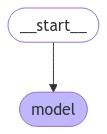

In [79]:
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated
from IPython.display import Image, display

# アプリケーションの状態を表すデータ構造
# rag_chainの入出力に合わせている
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str

# rag_chainを実行する単純なノードを定義
# ノードの戻り値でグラフの状態を更新する
def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        # 入力メッセージと応答メッセージで会話履歴を更新
        "chat_history": [
            HumanMessage(content=state["input"]),
            AIMessage(content=response["answer"])
        ],
        "context": response["context"],
        "answer": response["answer"]
    }


workflow = StateGraph(state_schema=State)
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# mermaidでグラフを可視化してPNG形式で出力
display(Image(app.get_graph().draw_mermaid_png()))

In [80]:
from langchain_core.runnables import RunnableConfig
from pprint import pprint

config = RunnableConfig(configurable={"thread_id": "123456"})
result = app.invoke({"input": "タスク分解とは何ですか。"}, config=config)
pprint(result)

{'answer': 'タスク分解とは、複雑なタスクをより小さくて簡単なステップに分解するプロセスです。これは、問題を解決しやすくするための手法で、モデルの思考過程を解釈するのに役立ちます。タスク分解は、Chain '
           'of Thought (CoT) や人間の入力を利用して行うことができます。',
 'chat_history': [HumanMessage(content='タスク分解とは何ですか。', additional_kwargs={}, response_metadata={}, id='bbffa7d4-a627-4921-8b51-b291e3eb0da9'),
                  AIMessage(content='タスク分解とは、複雑なタスクをより小さくて簡単なステップに分解するプロセスです。これは、問題を解決しやすくするための手法で、モデルの思考過程を解釈するのに役立ちます。タスク分解は、Chain of Thought (CoT) や人間の入力を利用して行うことができます。', additional_kwargs={}, response_metadata={}, id='ddfa4e3a-3bd3-48dd-8c7a-5f76ca4bf3da')],
 'context': [Document(id='003cc3f3-ddc4-423e-a9f0-58e5abffabd4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process

In [81]:
result = app.invoke({"input": "それは一般的な手法ですか。"}, config=config)
pprint(result)

{'answer': 'はい、タスク分解は複雑なタスクに対するモデルのパフォーマンスを向上させるための一般的な手法です。Chain of Thought '
           '(CoT) などのプロンプト技術として広く利用されています。',
 'chat_history': [HumanMessage(content='タスク分解とは何ですか。', additional_kwargs={}, response_metadata={}, id='bbffa7d4-a627-4921-8b51-b291e3eb0da9'),
                  AIMessage(content='タスク分解とは、複雑なタスクをより小さくて簡単なステップに分解するプロセスです。これは、問題を解決しやすくするための手法で、モデルの思考過程を解釈するのに役立ちます。タスク分解は、Chain of Thought (CoT) や人間の入力を利用して行うことができます。', additional_kwargs={}, response_metadata={}, id='ddfa4e3a-3bd3-48dd-8c7a-5f76ca4bf3da'),
                  HumanMessage(content='それは一般的な手法ですか。', additional_kwargs={}, response_metadata={}, id='351595d9-5891-4ad4-b9a8-5a10287cbceb'),
                  AIMessage(content='はい、タスク分解は複雑なタスクに対するモデルのパフォーマンスを向上させるための一般的な手法です。Chain of Thought (CoT) などのプロンプト技術として広く利用されています。', additional_kwargs={}, response_metadata={}, id='c0a7fd6b-551a-469d-aa1f-9310d901ea6a')],
 'context': [Document(id='003cc3f3-ddc4-423e-a9f0-58e5abffabd4', metadata={'source': 'https://lilianwen

In [82]:
# Graphのステートから会話履歴を確認してみる
chat_history = app.get_state(config).values["chat_history"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

タスク分解とは何ですか。
================================== Ai Message ==================================

タスク分解とは、複雑なタスクをより小さくて簡単なステップに分解するプロセスです。これは、問題を解決しやすくするための手法で、モデルの思考過程を解釈するのに役立ちます。タスク分解は、Chain of Thought (CoT) や人間の入力を利用して行うことができます。
================================ Human Message =================================

それは一般的な手法ですか。
================================== Ai Message ==================================

はい、タスク分解は複雑なタスクに対するモデルのパフォーマンスを向上させるための一般的な手法です。Chain of Thought (CoT) などのプロンプト技術として広く利用されています。
